In [1]:
import pandas as pd
import json
import datetime, time
from sklearn.model_selection import train_test_split
import itertools
import os
import zipfile

import numpy as np

import requests
import matplotlib.pyplot as plt

import scipy.sparse as sp
from sklearn.metrics import roc_auc_score


from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Flatten, Input, Layer
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model

# Read data

In [2]:
df_movies = pd.read_csv("data/movies_cast_company.csv", encoding='utf8')
df_movies["cast"] = df_movies["cast"].apply(lambda x: json.loads(x))
df_movies["company"] = df_movies["company"].apply(lambda x: json.loads(x))

# TODO: just temporary, later remove
additional_rows = ["title"]
df_movies = df_movies.drop(additional_rows+["url"]+list(df_movies.columns[-4:]), axis=1)

print(df_movies.shape)
df_movies.head()

(1315, 21)


,movie_id_ml,release,unknown,action,adventure,animation,childrens,comedy,crime,documentary,...,fantasy,noir,horror,musical,mystery,romance,scifi,thriller,war,western
0,1,1995,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1995,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,1995,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,1995,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1995,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [3]:
def string2ts(string, fmt="%Y-%m-%d %H:%M:%S"):
    dt = datetime.datetime.strptime(string, fmt)
    t_tuple = dt.timetuple()
    return int(time.mktime(t_tuple))

In [4]:
df_ratings = pd.read_csv("data/ratings.csv")

# TODO: just temporary, later remove
#additional_rows = ["rating_timestamp"]
df_ratings.rating_timestamp = df_ratings.rating_timestamp.apply(lambda x: string2ts(x))

print(df_ratings.shape)
df_ratings.head()

(100000, 4)


,user_id,movie_id_ml,rating,rating_timestamp
0,196,242,3,881247349
1,186,302,3,891710542
2,22,377,1,878883516
3,244,51,2,880603323
4,166,346,1,886393996


In [5]:
df_users = pd.read_csv("data/users.csv")

# TODO: just temporary, later remove
additional_rows = ["user_zipcode"]
df_users = df_users.drop(additional_rows, axis=1)

num2occupation = dict(enumerate(df_users.user_occupation.unique()))
occupation2num = {y:x for x,y in num2occupation.items()}
num2gender = dict(enumerate(df_users.user_gender.unique()))
gender2num = {y:x for x,y in num2gender.items()}
df_users.user_occupation = df_users.user_occupation.apply(lambda x: occupation2num[x])
df_users.user_gender = df_users.user_gender.apply(lambda x: gender2num[x])


print(df_users.shape)
df_users.head()

(943, 4)


,user_id,user_age,user_gender,user_occupation
0,1,24,0,0
1,2,53,1,1
2,3,23,0,2
3,4,24,0,0
4,5,33,1,1


In [6]:
df = pd.merge(df_movies, df_ratings, on="movie_id_ml")
df = pd.merge(df, df_users, on="user_id")

print(df.shape)
df.head()

(90851, 27)


,movie_id_ml,release,unknown,action,adventure,animation,childrens,comedy,crime,documentary,...,scifi,thriller,war,western,user_id,rating,rating_timestamp,user_age,user_gender,user_occupation
0,1,1995,0,0,0,1,1,1,0,0,...,0,0,0,0,308,4,887732932,60,0,18
1,4,1995,0,1,0,0,0,1,0,0,...,0,0,0,0,308,5,887734290,60,0,18
2,5,1995,0,0,0,0,0,0,1,0,...,0,1,0,0,308,4,887736008,60,0,18
3,7,1995,0,0,0,0,0,0,0,0,...,1,0,0,0,308,4,887735247,60,0,18
4,8,1995,0,0,0,0,1,1,0,0,...,0,0,0,0,308,5,887733096,60,0,18


In [7]:
id2movie = dict(enumerate(df.movie_id_ml.unique()))
movie2id = {y:x for x,y in id2movie.items()}

id2user = dict(enumerate(df.user_id.unique()))
user2id = {y:x for x,y in id2user.items()}

In [8]:
df["iid"] = df.apply(lambda x: movie2id[x.movie_id_ml], axis=1)
df["uid"] = df.apply(lambda x: user2id[x.user_id], axis=1)

In [9]:
df

,movie_id_ml,release,unknown,action,adventure,animation,childrens,comedy,crime,documentary,...,war,western,user_id,rating,rating_timestamp,user_age,user_gender,user_occupation,iid,uid
0,1,1995,0,0,0,1,1,1,0,0,...,0,0,308,4,887732932,60,0,18,0,0
1,4,1995,0,1,0,0,0,1,0,0,...,0,0,308,5,887734290,60,0,18,1,0
2,5,1995,0,0,0,0,0,0,1,0,...,0,0,308,4,887736008,60,0,18,2,0
3,7,1995,0,0,0,0,0,0,0,0,...,0,0,308,4,887735247,60,0,18,3,0
4,8,1995,0,0,0,0,1,1,0,0,...,0,0,308,5,887733096,60,0,18,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90846,748,1997,0,1,0,0,0,0,0,0,...,0,0,729,4,893279438,19,0,5,348,942
90847,751,1997,0,1,0,0,0,0,0,0,...,0,0,729,3,893279138,19,0,5,447,942
90848,879,1997,0,1,0,0,0,0,0,0,...,1,0,729,3,893279099,19,0,5,659,942
90849,894,1997,0,0,0,0,1,1,0,0,...,0,0,729,1,893279311,19,0,5,875,942


---

# Simulate our user input

First, `user_movie_ratings_training` is used to simulate initial user input that we will ask him to rate some random movies. Later, we will try to recommend movies to him, but we know what is his preference thanks to `user_movie_ratings_test`. Both lists are extracted from the existed dataset.

In [10]:
user_movie_ratings_training = [[942, 891, 4, 893279438],
                             [942, 130, 2, 893279061],
                             [942, 133, 2, 893279138],
                             [942, 488, 4, 893279438],
                             [942, 854, 3, 893279004],
                             [942, 137, 3, 893279438],
                             [942, 141, 4, 893279437],
                             [942, 609, 3, 893279438],
                             [942, 612, 4, 893279438],
                             [942, 857, 1, 893279173]]

user_movie_ratings_test = [[942, 343, 1, 893278968],
                         [942, 862, 5, 893279437],
                         [942, 1124, 4, 893279437],
                         [942, 918, 4, 893279438],
                         [942, 438, 2, 893278949],
                         [942, 348, 4, 893279438],
                         [942, 447, 3, 893279138],
                         [942, 659, 3, 893279099],
                         [942, 875, 1, 893279311],
                         [942, 878, 1, 893279291]]

In [11]:
# TODO; add real user data
# user initial input that will be given to him to rate it before recommendation
df_real_user_train = pd.DataFrame(user_movie_ratings_training, columns=["uid", "iid", "rating", "rating_timestamp"])
# the input that will be checked if recommendation works fine
df_real_user_test = pd.DataFrame(user_movie_ratings_test, columns=["uid", "iid", "rating", "rating_timestamp"])
new_user_id = user_movie_ratings_training[0][0]

_df = df[["uid", "iid", "rating", "rating_timestamp"]]
# TODO; remove this line when real user
_df = _df[_df.uid != new_user_id]

In [12]:
num_samples = _df.shape[0]

train_idx, test_idx = train_test_split(range(num_samples), test_size=0.2, random_state=42)

df_train = _df.iloc[train_idx]
df_train = pd.concat([df_train, df_real_user_train])

df_test = _df.iloc[test_idx]
df_test = pd.concat([df_test, df_real_user_test])

---

# Data Pre-Processing

In [13]:
train_data, test_data = df_train, df_test

uids = set(train_data.uid.unique()).union(set(test_data.uid.unique()))
iids = set(train_data.iid.unique()).union(set(test_data.iid.unique()))

rows = max(uids) + 1 
cols = max(iids) + 1

print("Users number: ", len(uids), rows)
print("Movies number: ", len(iids), cols)

Users number:  943 943
Movies number:  1280 1280


In [14]:
def _build_interaction_matrix(rows, cols, data):

    mat = sp.lil_matrix((rows, cols), dtype=np.int32)

    for uid, iid, rating, timestamp in data:
        # Let's assume only really good things are positives
        if rating >= 4.0:
            mat[uid, iid] = 1.0

    return mat.tocoo()

def get_triplets(mat):
    return mat.row, mat.col, np.random.randint(mat.shape[1], size=len(mat.row))

def create_sparse_matrix(df):
    """
    Return (train_interactions, test_interactions).
    """
    return _build_interaction_matrix(rows, cols, df.values.tolist())

---

Using ROC curve from [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc) and [here](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve).

In [15]:
def predict(model, uid, pids):
    user_vector = model.get_layer('user_embedding').get_weights()[0][uid]
    item_matrix = model.get_layer('item_embedding').get_weights()[0][pids]

    scores = (np.dot(user_vector,
                     item_matrix.T))

    return scores


def full_auc(model, ground_truth):
    """
    Measure AUC for model and ground truth on all items.

    Returns
    -------
    - float AUC
    """
    ground_truth = ground_truth.tocsr()

    no_users, no_items = ground_truth.shape

    pid_array = np.arange(no_items, dtype=np.int32)

    scores = []

    for user_id, row in enumerate(ground_truth):

        predictions = predict(model, user_id, pid_array)

        true_pids = row.indices[row.data == 1]

        grnd = np.zeros(no_items, dtype=np.int32)
        grnd[true_pids] = 1

        if len(true_pids):
            scores.append(roc_auc_score(grnd, predictions))

    return np.mean(scores)

---

# Model Implementation

Here, we add new custom layer called `TripletLossLayer`.

In [16]:
class TripletLossLayer(Layer):
    def call(self, inputs):
        positive_item_latent, negative_item_latent, user_latent = inputs

        # Bayesian Personalised Ranking (BPR) loss
        loss = 1.0 - K.sigmoid(
            K.sum(user_latent * positive_item_latent, axis=-1, keepdims=True) -
            K.sum(user_latent * negative_item_latent, axis=-1, keepdims=True))

        return loss

In [17]:
def identity_loss(y_true, y_pred):
    return K.mean(y_pred - 0 * y_true)

def build_model(num_users, num_items, latent_dim):

    positive_item_input = Input((1, ), name='positive_item_input')
    negative_item_input = Input((1, ), name='negative_item_input')

    # Shared embedding layer for positive and negative items
    item_embedding_layer = Embedding(num_items, latent_dim, name='item_embedding', input_length=1)
    user_input = Input((1, ), name='user_input')

    positive_item_embedding = Flatten()(item_embedding_layer(positive_item_input))
    negative_item_embedding = Flatten()(item_embedding_layer(negative_item_input))
    user_embedding = Flatten()(Embedding(num_users, latent_dim, name='user_embedding', input_length=1)(user_input))
    
    loss = TripletLossLayer()((positive_item_embedding, negative_item_embedding, user_embedding))
    
    model = Model([positive_item_input, negative_item_input, user_input], loss)
    
    model.compile(loss=identity_loss, optimizer=Adam())
    
    return model

In [18]:
# train.todense()

---

# Training

In [19]:
latent_dim = 100
num_epochs = 15

# Read data
train = create_sparse_matrix(df_train)
test = create_sparse_matrix(df_test)
num_users, num_items = train.shape

# Prepare the test triplets
test_uid, test_pid, test_nid = get_triplets(test)

model = build_model(num_users, num_items, latent_dim)

# Print the model structure
print(model.summary())

plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

# Sanity check, should be around 0.5
print(f'AUC before training {full_auc(model, test)}')



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
positive_item_input (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
negative_item_input (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 100)       128000      positive_item_input[0][0]        
                                                                 negative_item_input[0][0]    

In [20]:
accuracies_test = []
accuracies_train = []
losses = []

for epoch in range(num_epochs):

    print(f'Epoch {epoch}')

    # Sample triplets from the training data
    uid, pid, nid = get_triplets(train)

    X = {
        'user_input': uid,
        'positive_item_input': pid,
        'negative_item_input': nid
    }

    history = model.fit(X,
                      np.ones(len(uid)),
                      batch_size=64,
                      epochs=1,
                      verbose=1,
                      shuffle=True)
    loss = history.history["loss"]
    losses.append(loss)
    
    acc = full_auc(model, test)
    accuracies_test.append(acc)
    print(f'Test AUC {acc}')
    acc = full_auc(model, train)
    accuracies_train.append(acc)
    print(f'Train AUC {acc}\n')

Epoch 0
Train on 38252 samples
38252/38252 [==============================] - 2s 52us/sample - loss: 0.4900
Test AUC 0.8231062456085138
Train AUC 0.8785267718102268

Epoch 1
Train on 38252 samples
38252/38252 [==============================] - 1s 29us/sample - loss: 0.2869
Test AUC 0.8521139830354152
Train AUC 0.8718029293545843

Epoch 2
Train on 38252 samples
38252/38252 [==============================] - 1s 28us/sample - loss: 0.1923
Test AUC 0.8616845600112281
Train AUC 0.8813798629343648

Epoch 3
Train on 38252 samples
38252/38252 [==============================] - 1s 29us/sample - loss: 0.1694
Test AUC 0.8720625313134298
Train AUC 0.891658748320702

Epoch 4
Train on 38252 samples
38252/38252 [==============================] - 1s 30us/sample - loss: 0.1581
Test AUC 0.8804691431613653
Train AUC 0.9007966538203297

Epoch 5
Train on 38252 samples
38252/38252 [==============================] - 1s 28us/sample - loss: 0.1496
Test AUC 0.8868434562405895
Train AUC 0.9082741963058983

Epoch

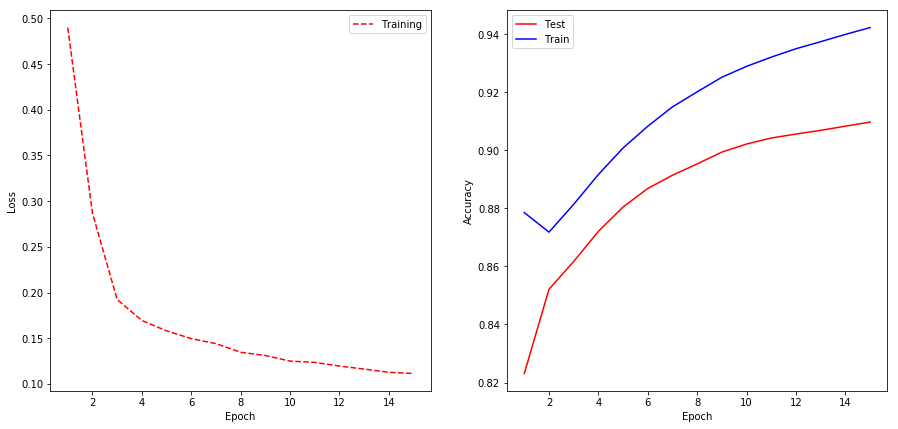

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

# Create count of the number of epochs
epoch_count = range(1, num_epochs + 1)

# Visualize loss history
ax1.plot(epoch_count, losses, 'r--', label='Training')
#ax1.plot(epoch_count, val_loss, 'b-', label='Validation')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(epoch_count, accuracies_test, 'r-', label='Test')
ax2.plot(epoch_count, accuracies_train, 'b-', label='Train')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
plt.show();

---

# Observe the recommendation results for our user

In [22]:
user_id = new_user_id
print(user_id)
movie_ids = [343, 862, 1124, 918, 438, 348, 447, 659, 875, 878]
print(movie_ids)

g = [0, 1, 1, 1, 0, 1, 0, 0, 0, 0]
print(g)
# = [1, 1, 0, 0, 1, 1]
# p is supposed to be the score of the class with greater label (if score is less than 0.5 with 1 decimal, then it predicted 0 otherwise it predicts 1)
p = predict(model, user_id, movie_ids)
print([1 if np.round(i)>0.5 else 0 for i in p])
print(roc_auc_score(g, p))

942
[343, 862, 1124, 918, 438, 348, 447, 659, 875, 878]
[0, 1, 1, 1, 0, 1, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
0.5


In [23]:
def predict_movies(model, user_id):
    movie_ids = list(_df.iid.unique())
    prediction = predict(model, user_id, movie_ids)
    rated_high = [1 if np.round(i)>0.5 else 0 for i in prediction]
    good_movie_ids = np.where(np.array(rated_high) == 1)[0]  
    return list(good_movie_ids)

In [24]:
predicted_good_movies = predict_movies(model, user_id)

In [25]:
user_ratings = user_movie_ratings_training + user_movie_ratings_test
user_ratings_positive = []
user_ratings_negative = []
for ur in user_ratings:
    if ur[2] >= 4:
        user_ratings_positive.append(ur[1])
    else:
        user_ratings_negative.append(ur[1])

In [26]:
for m in user_ratings_positive:
    print(m if m in predicted_good_movies else f"{m} PREDICTED WRONG: SHOULD BE GOOD MOVIE FOR THIS USER")

891
488
141
612
862
1124
918
348


In [27]:
for m in user_ratings_negative:
    print(m if m not in predicted_good_movies else f"{m} PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER")

130 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
133 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
854 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
137 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
609 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
857 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
343 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
438 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
447 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
659 PREDICTED WRONG: SHOULD BE BAD MOVIE FOR THIS USER
875
878


In [28]:
user_sparse_matrix = create_sparse_matrix(df_real_user_test)
full_auc(model, user_sparse_matrix)

0.9314263322884012

Accuracy **93.1%** for this user is not bad, could be better! On the test set, accuracy on average is **90.9%**.